## Identifying a subset of questionnaire questions to predict transdiagnostic factors

### Aim and approach

We wish to identify a subset of questions which can acccurately predict factor scores on the three transdiagnostic symptom dimensions identified by [Gillan et al (2016)](https://elifesciences.org/articles/11305), without having to ask all 209 questions. To do this, we train a multi-target lasso regression model on data from their Experiment 2 (n=1400), which can be found on [OSF](https://osf.io/usdgt/), using 5-fold cross validation to optimise the alpha hyperparameter, and find how many questions are needed to predict the factor scores with reasonably high accuracy.

The method and Python code here is adapted from (and broadly identical to) that used by [Wise & Dolan (2020)](https://www.nature.com/articles/s41467-020-17977-w), which was shared on [GitHub](https://github.com/tobywise/online-aversive-learning/blob/master/notebooks/questionnaire_analysis.ipynb). The only difference is that they used a different set of questionnaire data from [Rouault et al. (2018)](https://pubmed.ncbi.nlm.nih.gov/29458997/). While in this study the same 209 questions were asked, it had less fine-grained Likert scoring for the Eating Attitudes Test (scored 0-3 vs 0-5) compared to the original study by [Gillan et al (2016)](https://elifesciences.org/articles/11305). This may have reduced the predictive accuracy of subsets of questions for the "compulsivity" factor.

### Setup

**Fix data paths, import dependencies, and import data**

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
import os, joblib, rpy2
from sklearn.metrics import r2_score
from tqdm import tqdm

light_pal = ["#ffc9b5", "#b1ddf1", "#987284"]

os.chdir('..')
    # run initially as cd will be the notebook folder otherwise
%load_ext rpy2.ipython
    # warnings about 'quartz' on Windows can be safely ignored.

qns = pd.read_csv('data-raw/gillan_qns.csv').iloc[:,1:] #remove row numbers
scores = pd.read_csv('data-raw/gillan_scores.csv').iloc[:,1:]

c:\users\qderc\appdata\local\programs\python\python39\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
%%R
devtools::load_all()

i Loading pstpipeline


In [4]:
qns.head()
scores.head()

,id,AD,CIT,SW
0,304SM51WA34XCM4E67SL28LY2UCBS4,3.054589,2.736297,1.644239
1,308Q0PEVB8DPUFML3BKB70KL51T9IW,2.665920,1.506195,1.528145
2,308Q0PEVB8DPUFML3BKB70KL6Q8I9Z,1.629748,1.656867,0.665719
3,308XBLVESI4LB741RISGCYG2G16RBR,1.910352,2.134919,0.352836
4,30BUDKLTXDVUDNIN42H3A5HRS51E5M,3.491979,2.284549,1.204889


### Fit model

**Hyperparameter optimisation**

Loop over candidate alpha values and record $R^2$ and number of items with non-zero coefficients following 5-fold cross-validation.

In [5]:
clf = Lasso()

alpha_values = [
    0.001, 0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7
]
r2_values = np.empty((3, len(alpha_values)))
n_items = np.empty(len(alpha_values))

# iloc.[:, 1:] used throughout to remove id column
for n, alpha in enumerate(tqdm(alpha_values)):
    clf = Lasso(alpha = alpha)
    clf.fit(qns.iloc[:, 1:], scores.iloc[:, 1:]);
    pred = cross_val_predict(clf, qns.iloc[:, 1:], scores.iloc[:, 1:], cv = 5)
    for i in range(3):
        r2_values[i, n] = r2_score(scores.iloc[:, i+1], pred[:, i])
    n_items[n] = np.any(clf.coef_.T != 0, axis = 1).sum()

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.01it/s]


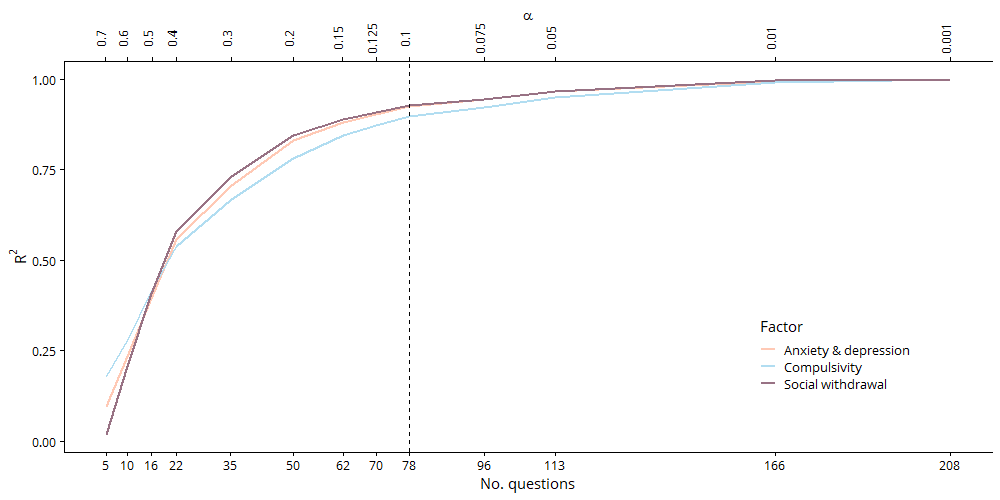

In [16]:
%%R -i r2_values -i light_pal -i alpha_values -i n_items -w 10 -h 5 --units in -r 100

factor_names = c('Anxiety & depression', 'Compulsivity', 'Social withdrawal')
dimnames(r2_values) <- list(factor_names, paste(alpha_values, n_items, sep = "_"))

pstpipeline::plot_factors(
    r2_values, plot_type = "r2_plot", hyp_alph = 0.1, pal = light_pal, 
    font = "Open Sans"
)
# ggplot2::ggsave('notebooks/plots/R2_plot.png', device = "png")

An alpha value of 0.1 looks like it gives a good balance between accurate predictions and a number of questions.

**Predict factor scores and identify question subset**

Using alpha=0.1 and 5-fold CV:

In [17]:
clf = Lasso(alpha=0.1)
pred = cross_val_predict(clf, qns.iloc[:, 1:], scores.iloc[:, 1:], cv=5)

clf.fit(qns.iloc[:, 1:], scores.iloc[:, 1:]);
coefs = clf.coef_.T

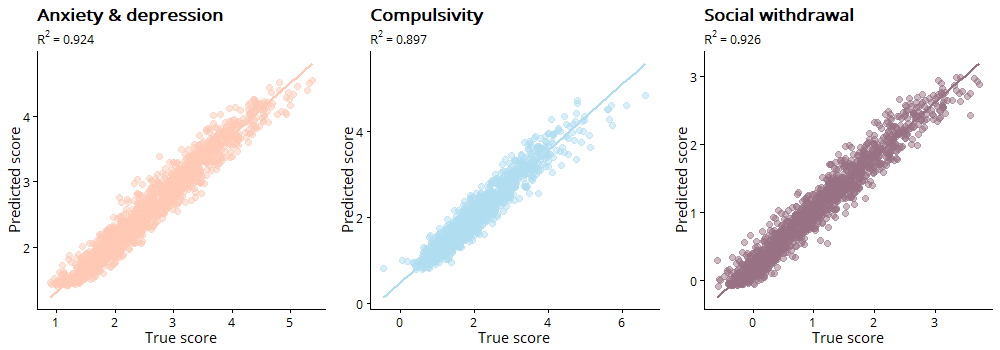

In [18]:
%%R -i scores -i pred -i light_pal -w 10 -h 3.5 --units in -r 100

factors = c("AD", "CIT", "SW")
pstpipeline::plot_factors(
    list("preds" = pred, "scores" = scores), plot_type = "predictive", 
    colnames = factors, titles = factor_names, r2 = r2_values, qn = 78, 
    pal = light_pal, font = "Open Sans"
)
# ggplot2::ggsave('notebooks/plots/alpha01_gillan.png', device = "png")

This indeed seems to do a good job of predicting true factor scores, including for compulsivity. 

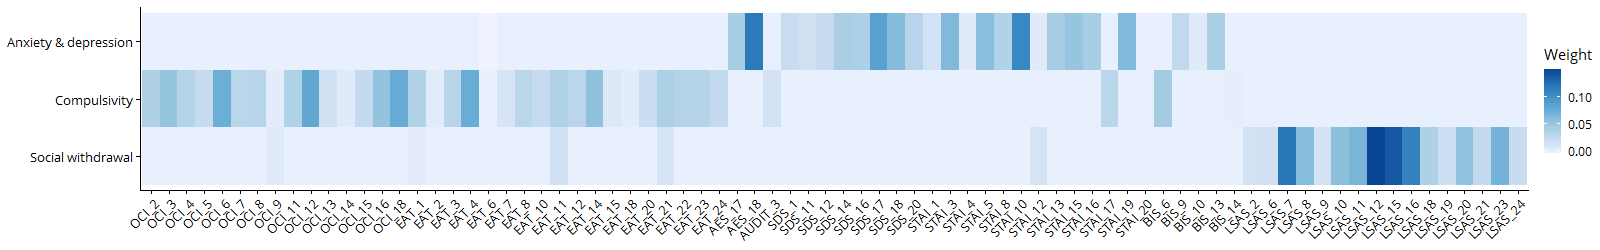

In [19]:
%%R -i coefs -i qns -w 16 -h 2.5 --units in -r 100

pstpipeline::plot_factors(
    list("qns" = qns, "coefs" = coefs), plot_type = "factor_htmp", colnames = factors, 
    titles = factor_names, font = "Open Sans"
)
# ggplot2::ggsave('notebooks/plots/question_subset_heatmap.png', device = "png")

We can see here the 78 included questions (other questions have all three weights = 0). These appear to be fairly specific to the factors; i.e., few questions have weights > 0 for more than 1 factor.

In [8]:
# save classifier
joblib.dump(clf, 'outputs/factor_prediction/gillan_classifier_78.pkl')

# save item weights
weight_df = pd.DataFrame(coefs, columns=['Anxiety/depression', 'Compulsivity', 'Social withdrawal'], index=np.arange(coefs.shape[0]))
weight_df['item'] = qns.columns[1:]
weight_df.to_csv('outputs/factor_prediction/gillan_classifier_weights_78.csv', index=None)

# save list of questions
reduced_qns = (qns.iloc[:,1:]).iloc[:, np.any(clf.coef_.T != 0, axis = 1)]
reduced_qns.to_csv('outputs/factor_prediction/reduced_qns_gillan_78.csv')